In [ ]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())


2.10.0+cpu
CUDA available: False


### Second Part: UL Data Loading and Pre-processing

The dataset is loaded from a pre-cleaned CSV file. Only two core system-level features are used as model inputs:
- `airtime`
- `selected_mcs`

The target variable is `pm_power`, representing power consumption.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1) load data
df = pd.read_csv("clean_ul_stage1.csv")

# （Use airtime for bin; otherwise, the group will be too fragmented
df["airtime_bin"] = pd.to_numeric(df["airtime"], errors="coerce").round(1)

FEATURE_SETS = {
    "gain": ["txgain"],
    "mcs": ["selected_mcs"],
    "airtime": ["airtime_bin"],   # bin
}

target_col = "pm_power"


def groupwise_split_df(d, group_col, train_ratio=0.8, val_ratio_within_train=0.1, seed=42, min_group_size=5):
    train_parts, val_parts, test_parts = [], [], []
    d2 = d.dropna(subset=[group_col]).copy()

    for gval, gdf in d2.groupby(group_col):
        if len(gdf) < min_group_size:
            continue

        g_train, g_test = train_test_split(gdf, test_size=(1-train_ratio), random_state=seed)
        g_train, g_val  = train_test_split(g_train, test_size=val_ratio_within_train, random_state=seed)

        train_parts.append(g_train)
        val_parts.append(g_val)
        test_parts.append(g_test)

    train_df = pd.concat(train_parts, ignore_index=True)
    val_df   = pd.concat(val_parts,   ignore_index=True)
    test_df  = pd.concat(test_parts,  ignore_index=True)
    return train_df, val_df, test_df


for name, feature_cols in FEATURE_SETS.items():
    print(f"\n===== {name} | features={feature_cols} =====")

    # 2) clean data for THIS feature set
    cols_needed = feature_cols + [target_col]
    d = df.dropna(subset=cols_needed).copy()

    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")

    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()

    # 3) group-wise split 
    group_col = feature_cols[0]
    train_df, val_df, test_df = groupwise_split_df(d, group_col=group_col, seed=42, min_group_size=5)

    # 4) build X/y
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values

    # 5) scale (fit ONLY on train)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    print("Shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)

   


Shapes: (4153, 3) (462, 3) (1154, 3)


In [37]:
# ====== UL: One shared tensor set for all models ======
X_train_tensor = torch.FloatTensor(X_train_s)
X_val_tensor   = torch.FloatTensor(X_val_s)
X_test_tensor  = torch.FloatTensor(X_test_s)

y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
y_val_tensor   = torch.FloatTensor(y_val).view(-1, 1)
y_test_tensor  = torch.FloatTensor(y_test).view(-1, 1)

y_true_ul = y_test_tensor.numpy().flatten()  
print("UL test size:", len(y_true_ul))


UL test size: 1154


In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1) load data
df = pd.read_csv("clean_ul_stage1.csv")

# Use airtime for bin; otherwise, the group will be too fragmented
df["airtime_bin"] = pd.to_numeric(df["airtime"], errors="coerce").round(1)

FEATURE_SETS = {
    "gain": ["txgain"],
    "mcs": ["selected_mcs"],
    "airtime": ["airtime_bin"],   # bin
}

target_col = "pm_power"


def groupwise_split_df(d, group_col, train_ratio=0.8, val_ratio_within_train=0.1, seed=42, min_group_size=5):
    train_parts, val_parts, test_parts = [], [], []
    d2 = d.dropna(subset=[group_col]).copy()

    for gval, gdf in d2.groupby(group_col):
        if len(gdf) < min_group_size:
            continue

        g_train, g_test = train_test_split(gdf, test_size=(1-train_ratio), random_state=seed)
        g_train, g_val  = train_test_split(g_train, test_size=val_ratio_within_train, random_state=seed)

        train_parts.append(g_train)
        val_parts.append(g_val)
        test_parts.append(g_test)

    train_df = pd.concat(train_parts, ignore_index=True)
    val_df   = pd.concat(val_parts,   ignore_index=True)
    test_df  = pd.concat(test_parts,  ignore_index=True)
    return train_df, val_df, test_df


for name, feature_cols in FEATURE_SETS.items():
    print(f"\n===== {name} | features={feature_cols} =====")

    # 2) clean data for THIS feature set
    cols_needed = feature_cols + [target_col]
    d = df.dropna(subset=cols_needed).copy()

    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")

    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()

    # 3) group-wise split 
    group_col = feature_cols[0]
    train_df, val_df, test_df = groupwise_split_df(d, group_col=group_col, seed=42, min_group_size=5)

    # 4) build X/y
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values

    # 5) scale (fit ONLY on train)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    print("Shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)



===== gain | features=['txgain'] =====
Shapes: (4135, 1) (476, 1) (1158, 1)

===== mcs | features=['selected_mcs'] =====
Shapes: (4147, 1) (466, 1) (1156, 1)

===== airtime | features=['airtime_bin'] =====
Shapes: (4145, 1) (465, 1) (1159, 1)


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# =========================
# 0) Utils
# =========================
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)
    def __len__(self): 
        return len(self.X)
    def __getitem__(self, idx): 
        return self.X[idx], self.y[idx]

#three fully connected hidden layers with 64, 64, and 32 neurons

class BaselineDNN(nn.Module):
    """Model 1 (your baseline)"""
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x): 
        return self.net(x)


def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)


def groupwise_split_df(d, group_col, train_ratio=0.8, val_ratio_within_train=0.1, seed=42, min_group_size=5):
    """
    Group-wise split:
    For each group:
      - 80% train / 20% test
      - within train: 10% val
    """
    train_parts, val_parts, test_parts = [], [], []
    d2 = d.dropna(subset=[group_col]).copy()

    for gval, gdf in d2.groupby(group_col):
        if len(gdf) < min_group_size:
            continue

        g_train, g_test = train_test_split(
            gdf, test_size=(1 - train_ratio), random_state=seed
        )
        g_train, g_val = train_test_split(
            g_train, test_size=val_ratio_within_train, random_state=seed
        )

        train_parts.append(g_train)
        val_parts.append(g_val)
        test_parts.append(g_test)

    if len(train_parts) == 0:
        raise ValueError(f"No groups large enough after grouping by '{group_col}'. "
                         f"Try reducing min_group_size or binning the variable.")

    train_df = pd.concat(train_parts, ignore_index=True)
    val_df   = pd.concat(val_parts,   ignore_index=True)
    test_df  = pd.concat(test_parts,  ignore_index=True)
    return train_df, val_df, test_df


# =========================
# 1) Train + Evaluate (Model1)
# =========================
def train_eval_model1(
    train_df, val_df, test_df,
    feature_cols, target_col,
    epochs=100, batch_size=64, lr=1e-3, seed=42,
    verbose_every=10
):
    # Reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Build arrays
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values

    # Scale (fit only on train)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    # DataLoaders
    train_loader = DataLoader(TabularDataset(X_train_s, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TabularDataset(X_val_s,   y_val),   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(TabularDataset(X_test_s,  y_test),  batch_size=batch_size, shuffle=False)

    # Model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = BaselineDNN(in_dim=len(feature_cols)).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    best_state = None

    print(f"\n[Model1] Training | features={feature_cols} | device={device}")
    print(f"Train/Val/Test sizes: {len(train_df)}/{len(val_df)}/{len(test_df)}")
    print(f"Scaled shapes: {X_train_s.shape}, {X_val_s.shape}, {X_test_s.shape}")

    for epoch in range(1, epochs + 1):
        # ---- train ----
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            train_loss += loss.item() * len(xb)
        train_loss /= len(train_loader.dataset)

        # ---- val ----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item() * len(xb)
        val_loss /= len(val_loader.dataset)

        # keep best
        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | train MSE {train_loss:.6f} | val MSE {val_loss:.6f}")

    # load best
    model.load_state_dict(best_state)
    print("Best val MSE:", best_val)

    # ---- test prediction ----
    model.eval()
    y_true_list, y_pred_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy().reshape(-1)
            y_pred_list.append(pred)
            y_true_list.append(yb.numpy().reshape(-1))

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "mre_pct": mre,
        "y_true": y_true,
        "y_pred": y_pred,
        "scaler": scaler,
        "model": model,
    }


# =========================
# 2) Main: loop over feature sets and print a results table
# =========================
df = pd.read_csv("clean_ul_stage1.csv")

# Airtime binning is strongly recommended for group-wise split
df["airtime_bin"] = pd.to_numeric(df["airtime"], errors="coerce").round(1)

FEATURE_SETS = {
    "gain": ["txgain"],
    "mcs": ["selected_mcs"],
    "airtime": ["airtime_bin"],
}

target_col = "pm_power"

results = []
test_outputs_m3 = {}

for feat_name, feature_cols in FEATURE_SETS.items():
    print(f"\n==============================")
    print(f"Feature set: {feat_name} -> {feature_cols}")
    print(f"==============================")

    cols_needed = feature_cols + [target_col]
    d = df.dropna(subset=cols_needed).copy()

    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()

    # keep target positive (for MRE stability)
    d = d[d[target_col] > 0].copy()

    group_col = feature_cols[0]
    train_df, val_df, test_df = groupwise_split_df(d, group_col=group_col, seed=42, min_group_size=5)

    out = train_eval_model1(
        train_df, val_df, test_df,
        feature_cols=feature_cols,
        target_col=target_col,
        epochs=100, batch_size=64, lr=1e-3, seed=42, verbose_every=10
    )

    # Save test predictions for plotting later
    test_outputs_m3[feat_name] = {
        "test_df": test_df.copy(),
        "y_true": out["y_true"],
        "y_pred_m3": out["y_pred"]
    }

    results.append({
        "feature_set": feat_name,
        "model": "Model1 (BaselineDNN)",
        "features": ",".join(feature_cols),
        "MSE": out["mse"],
        "RMSE": out["rmse"],
        "MAE": out["mae"],
        "MRE(%)": out["mre_pct"],
        "n_train": len(train_df),
        "n_val": len(val_df),
        "n_test": len(test_df),
    })

# Final results table
results_df = pd.DataFrame(results)
display(results_df)

print("\n=== Summary (sorted by MSE) ===")
print(results_df.sort_values("MSE")[["feature_set","model","MSE","RMSE","MAE","MRE(%)","n_train","n_val","n_test"]])



Feature set: gain -> ['txgain']

[Model1] Training | features=['txgain'] | device=cpu
Train/Val/Test sizes: 4135/476/1158
Scaled shapes: (4135, 1), (476, 1), (1158, 1)
Epoch 001 | train MSE 77.019218 | val MSE 7.140491
Epoch 010 | train MSE 0.513826 | val MSE 0.673127
Epoch 020 | train MSE 0.516794 | val MSE 0.679324
Epoch 030 | train MSE 0.512575 | val MSE 0.676157
Epoch 040 | train MSE 0.513445 | val MSE 0.675072
Epoch 050 | train MSE 0.513558 | val MSE 0.674122
Epoch 060 | train MSE 0.513147 | val MSE 0.679807
Epoch 070 | train MSE 0.518843 | val MSE 0.691080
Epoch 080 | train MSE 0.515593 | val MSE 0.678595
Epoch 090 | train MSE 0.526884 | val MSE 0.690190
Epoch 100 | train MSE 0.527525 | val MSE 0.684584
Best val MSE: 0.6724254223478943

Feature set: mcs -> ['selected_mcs']

[Model1] Training | features=['selected_mcs'] | device=cpu
Train/Val/Test sizes: 4147/466/1156
Scaled shapes: (4147, 1), (466, 1), (1156, 1)
Epoch 001 | train MSE 78.439753 | val MSE 4.506013
Epoch 010 | trai

,feature_set,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,Model1 (BaselineDNN),txgain,0.532540,0.729754,0.607649,5.226541,4135,476,1158
1,mcs,Model1 (BaselineDNN),selected_mcs,0.509418,0.713735,0.585849,5.082046,4147,466,1156
2,airtime,Model1 (BaselineDNN),airtime_bin,0.196696,0.443504,0.340591,2.928249,4145,465,1159



=== Summary (sorted by MSE) ===
  feature_set                 model       MSE      RMSE       MAE    MRE(%)  \
2     airtime  Model1 (BaselineDNN)  0.196696  0.443504  0.340591  2.928249   
1         mcs  Model1 (BaselineDNN)  0.509418  0.713735  0.585849  5.082046   
0        gain  Model1 (BaselineDNN)  0.532540  0.729754  0.607649  5.226541   

   n_train  n_val  n_test  
2     4145    465    1159  
1     4147    466    1156  
0     4135    476    1158  


## Model 2: Regularised Deep Neural Network (DNN)

To address the overfitting observed in the baseline model, we implement a regularised DNN architecture following the Cam-Ready paper design.

### Architecture

- Input layer: number of neurons = number of input features  
- Hidden Layer 1: 128 neurons  
- Hidden Layer 2: 64 neurons  
- Hidden Layer 3: 32 neurons  
- Output layer: 1 neuron (predicting continuous power consumption)

### Regularisation Techniques

- ReLU activation
- Batch Normalisation before activation
- Dropout (p = 0.3) after each hidden layer
- L2 weight decay (λ = 0.01)
- Adam optimizer
- MSE loss function
- Batch size = 64



In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# =========================
# 0) Utils
# =========================
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)


def groupwise_split_df(d, group_col, train_ratio=0.8, val_ratio_within_train=0.1, seed=42, min_group_size=5):
    train_parts, val_parts, test_parts = [], [], []
    d2 = d.dropna(subset=[group_col]).copy()

    for gval, gdf in d2.groupby(group_col):
        if len(gdf) < min_group_size:
            continue

        g_train, g_test = train_test_split(gdf, test_size=(1-train_ratio), random_state=seed)
        g_train, g_val  = train_test_split(g_train, test_size=val_ratio_within_train, random_state=seed)

        train_parts.append(g_train)
        val_parts.append(g_val)
        test_parts.append(g_test)

    if len(train_parts) == 0:
        raise ValueError(f"No groups large enough after grouping by '{group_col}'. "
                         f"Try reducing min_group_size or binning the variable.")

    train_df = pd.concat(train_parts, ignore_index=True)
    val_df   = pd.concat(val_parts,   ignore_index=True)
    test_df  = pd.concat(test_parts,  ignore_index=True)
    return train_df, val_df, test_df


# =========================
# 1) Model2 definition (RegularizedDNN)
# =========================
class RegularizedDNN(nn.Module):
    def __init__(self, input_dim, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# =========================
# 2) Train + Evaluate Model2 (same style as Model1)
# =========================
def train_eval_model2(
    train_df, val_df, test_df,
    feature_cols, target_col,
    epochs=200, batch_size=64, lr=1e-3, weight_decay=1e-2,
    seed=42, verbose_every=10
):
    # Reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Build arrays
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values

    # Scale (fit only on train)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    # Torch tensors
    X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
    y_train_t = torch.tensor(y_train,   dtype=torch.float32).view(-1, 1)
    X_val_t   = torch.tensor(X_val_s,   dtype=torch.float32)
    y_val_t   = torch.tensor(y_val,     dtype=torch.float32).view(-1, 1)
    X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32)
    y_test_t  = torch.tensor(y_test,    dtype=torch.float32).view(-1, 1)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = RegularizedDNN(input_dim=X_train_s.shape[1], dropout=0.3).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = float("inf")
    best_state = None

    print(f"\n[Model2] Training | features={feature_cols} | device={device}")
    print(f"Train/Val/Test sizes: {len(train_df)}/{len(val_df)}/{len(test_df)}")
    print(f"Scaled shapes: {X_train_s.shape}, {X_val_s.shape}, {X_test_s.shape}")
    print(f"epochs={epochs}, batch={batch_size}, lr={lr}, weight_decay={weight_decay}, dropout=0.3")

    for epoch in range(1, epochs + 1):
        # ---- train (mini-batch like your original model2) ----
        model.train()
        perm = torch.randperm(X_train_t.size(0))

        for i in range(0, X_train_t.size(0), batch_size):
            idx = perm[i:i+batch_size]
            xb = X_train_t[idx].to(device)
            yb = y_train_t[idx].to(device)

            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        # ---- epoch-end evaluation: train MSE & val MSE ----
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train_t.to(device))
            val_pred   = model(X_val_t.to(device))
            train_mse  = criterion(train_pred, y_train_t.to(device)).item()
            val_mse    = criterion(val_pred,   y_val_t.to(device)).item()

        if val_mse < best_val:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | train MSE {train_mse:.6f} | val MSE {val_mse:.6f}")

    # load best checkpoint
    model.load_state_dict(best_state)
    print("Best val MSE:", best_val)

    # ---- test prediction ----
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_t.to(device)).cpu().numpy().reshape(-1)
    y_true = y_test_t.numpy().reshape(-1)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": mse, "rmse": rmse, "mae": mae, "mre_pct": mre,
        "y_true": y_true, "y_pred": y_pred,
        "scaler": scaler, "model": model
    }


# =========================
# 3) Main: loop feature sets -> train Model2 -> results table
# =========================
df = pd.read_csv("clean_ul_stage1.csv")

# (recommended) airtime binning for stable group-wise split
df["airtime_bin"] = pd.to_numeric(df["airtime"], errors="coerce").round(1)

FEATURE_SETS = {
    "gain": ["txgain"],
    "mcs": ["selected_mcs"],
    "airtime": ["airtime_bin"],
}

target_col = "pm_power"

results = []
test_outputs_m2 = {}

for feat_name, feature_cols in FEATURE_SETS.items():
    print(f"\n==============================")
    print(f"Feature set: {feat_name} -> {feature_cols}")
    print(f"==============================")

    cols_needed = feature_cols + [target_col]
    d = df.dropna(subset=cols_needed).copy()

    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()

    group_col = feature_cols[0]
    train_df, val_df, test_df = groupwise_split_df(d, group_col=group_col, seed=42, min_group_size=5)

    out = train_eval_model2(
        train_df, val_df, test_df,
        feature_cols=feature_cols,
        target_col=target_col,
        epochs=200, batch_size=64, lr=1e-3, weight_decay=1e-2,
        seed=42, verbose_every=10
    )

    # Save test predictions for plotting later
    test_outputs_m2[feat_name] = {
        "test_df": test_df.copy(),
        "y_true": out["y_true"],
        "y_pred_m3": out["y_pred"]
    }

    results.append({
        "feature_set": feat_name,
        "model": "Model2 (RegularizedDNN)",
        "features": ",".join(feature_cols),
        "MSE": out["mse"],
        "RMSE": out["rmse"],
        "MAE": out["mae"],
        "MRE(%)": out["mre_pct"],
        "n_train": len(train_df),
        "n_val": len(val_df),
        "n_test": len(test_df),
    })

results_df = pd.DataFrame(results)
display(results_df)

print("\n=== Summary (sorted by MSE) ===")
print(results_df.sort_values("MSE")[["feature_set","model","MSE","RMSE","MAE","MRE(%)","n_train","n_val","n_test"]])



Feature set: gain -> ['txgain']

[Model2] Training | features=['txgain'] | device=cpu
Train/Val/Test sizes: 4135/476/1158
Scaled shapes: (4135, 1), (476, 1), (1158, 1)
epochs=200, batch=64, lr=0.001, weight_decay=0.01, dropout=0.3
Epoch 001 | train MSE 113.661972 | val MSE 114.293846
Epoch 010 | train MSE 0.820685 | val MSE 1.002449
Epoch 020 | train MSE 0.674680 | val MSE 0.854900
Epoch 030 | train MSE 0.616299 | val MSE 0.780326
Epoch 040 | train MSE 0.593284 | val MSE 0.761944
Epoch 050 | train MSE 0.664202 | val MSE 0.845184
Epoch 060 | train MSE 0.645610 | val MSE 0.821491
Epoch 070 | train MSE 0.596939 | val MSE 0.771504
Epoch 080 | train MSE 0.581344 | val MSE 0.755121
Epoch 090 | train MSE 0.631240 | val MSE 0.813941
Epoch 100 | train MSE 0.623818 | val MSE 0.803127
Epoch 110 | train MSE 0.675163 | val MSE 0.853663
Epoch 120 | train MSE 0.586282 | val MSE 0.759881
Epoch 130 | train MSE 0.540920 | val MSE 0.723415
Epoch 140 | train MSE 0.601125 | val MSE 0.780624
Epoch 150 | tr

,feature_set,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,Model2 (RegularizedDNN),txgain,0.545030,0.738262,0.615479,5.272784,4135,476,1158
1,mcs,Model2 (RegularizedDNN),selected_mcs,0.528000,0.726636,0.597469,5.161645,4147,466,1156
2,airtime,Model2 (RegularizedDNN),airtime_bin,0.198065,0.445045,0.333592,2.850694,4145,465,1159



=== Summary (sorted by MSE) ===
  feature_set                    model       MSE      RMSE       MAE  \
2     airtime  Model2 (RegularizedDNN)  0.198065  0.445045  0.333592   
1         mcs  Model2 (RegularizedDNN)  0.528000  0.726636  0.597469   
0        gain  Model2 (RegularizedDNN)  0.545030  0.738262  0.615479   

     MRE(%)  n_train  n_val  n_test  
2  2.850694     4145    465    1159  
1  5.161645     4147    466    1156  
0  5.272784     4135    476    1158  


## Model 3: Hybrid DNN–XGBoost (DNN Feature Extractor + XGBoost Regressor)

This model follows the hybrid pipeline described in the Cam-Ready paper.  
The key idea is to split the learning process into two stages:

1) A DNN is trained as a **feature extractor** to learn compact latent representations.  
2) The DNN is frozen, and a separate **XGBoost regressor** is trained on the extracted embeddings.

### DNN Feature Extractor Architecture
- Dense layers: 587 → 261 → 186 → 99
- Bottleneck embedding layer: 16 neurons
- Output head (for DNN training): 1 neuron (MSE loss)

### XGBoost Regressor (trained on embeddings)
- max_depth = 5
- n_estimators = 256
- learning_rate = 0.22


In [56]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

from xgboost import XGBRegressor


# =========================
# 0) Utils
# =========================
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)


def groupwise_split_df(d, group_col, train_ratio=0.8, val_ratio_within_train=0.1, seed=42, min_group_size=5):
    train_parts, val_parts, test_parts = [], [], []
    d2 = d.dropna(subset=[group_col]).copy()

    for gval, gdf in d2.groupby(group_col):
        if len(gdf) < min_group_size:
            continue

        g_train, g_test = train_test_split(gdf, test_size=(1-train_ratio), random_state=seed)
        g_train, g_val  = train_test_split(g_train, test_size=val_ratio_within_train, random_state=seed)

        train_parts.append(g_train)
        val_parts.append(g_val)
        test_parts.append(g_test)

    if len(train_parts) == 0:
        raise ValueError(f"No groups large enough after grouping by '{group_col}'. "
                         f"Try reducing min_group_size or binning the variable.")

    train_df = pd.concat(train_parts, ignore_index=True)
    val_df   = pd.concat(val_parts,   ignore_index=True)
    test_df  = pd.concat(test_parts,  ignore_index=True)
    return train_df, val_df, test_df


# =========================
# 1) Model3: Hybrid DNN Feature Extractor
# =========================
class HybridFeatureExtractor(nn.Module):
    """
    DNN feature extractor with 16-dim bottleneck embeddings + a regression head.
    Train end-to-end with MSE, then freeze and extract embeddings for XGBoost.
    """
    def __init__(self, input_dim):
        super().__init__()
        self.feature_net = nn.Sequential(
            nn.Linear(input_dim, 587),
            nn.ReLU(),
            nn.Linear(587, 261),
            nn.ReLU(),
            nn.Linear(261, 186),
            nn.ReLU(),
            nn.Linear(186, 99),
            nn.ReLU(),
            nn.Linear(99, 16)   # bottleneck
        )
        self.reg_head = nn.Linear(16, 1)

    def forward(self, x):
        emb = self.feature_net(x)
        out = self.reg_head(emb)
        return out, emb


# =========================
# 2) Train + Evaluate Model3 (same style as Model1/2)
# =========================
def train_eval_model3(
    train_df, val_df, test_df,
    feature_cols, target_col,
    epochs=200, batch_size=64, lr=1e-3,
    seed=42, verbose_every=10,
    # XGBoost params (use your current ones)
    xgb_params=None
):
    # Reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Build arrays
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values

    # Scale (fit only on train)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    # Torch tensors
    X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
    y_train_t = torch.tensor(y_train,   dtype=torch.float32).view(-1, 1)
    X_val_t   = torch.tensor(X_val_s,   dtype=torch.float32)
    y_val_t   = torch.tensor(y_val,     dtype=torch.float32).view(-1, 1)
    X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32)
    y_test_t  = torch.tensor(y_test,    dtype=torch.float32).view(-1, 1)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    dnn = HybridFeatureExtractor(input_dim=X_train_s.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(dnn.parameters(), lr=lr, weight_decay=0.01)

    best_val = float("inf")
    best_state = None

    print(f"\n[Model3] Training DNN stage | features={feature_cols} | device={device}")
    print(f"Train/Val/Test sizes: {len(train_df)}/{len(val_df)}/{len(test_df)}")
    print(f"Scaled shapes: {X_train_s.shape}, {X_val_s.shape}, {X_test_s.shape}")
    print(f"epochs={epochs}, batch={batch_size}, lr={lr}")

    for epoch in range(1, epochs + 1):
        dnn.train()
        perm = torch.randperm(X_train_t.size(0))

        for i in range(0, X_train_t.size(0), batch_size):
            idx = perm[i:i+batch_size]
            bx = X_train_t[idx].to(device)
            by = y_train_t[idx].to(device)

            optimizer.zero_grad()
            pred, _ = dnn(bx)
            loss = criterion(pred, by)
            loss.backward()
            optimizer.step()

        # epoch-end eval: train/val MSE
        dnn.eval()
        with torch.no_grad():
            train_pred, _ = dnn(X_train_t.to(device))
            val_pred, _   = dnn(X_val_t.to(device))
            train_mse = criterion(train_pred, y_train_t.to(device)).item()
            val_mse   = criterion(val_pred,   y_val_t.to(device)).item()

        if val_mse < best_val:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in dnn.state_dict().items()}

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | train MSE {train_mse:.6f} | val MSE {val_mse:.6f}")

    # ✅ load best checkpoint (important!)
    dnn.load_state_dict(best_state)
    print("Best val MSE:", best_val)

    # ---- extract embeddings ----
    dnn.eval()
    with torch.no_grad():
        _, emb_train = dnn(X_train_t.to(device))
        _, emb_test  = dnn(X_test_t.to(device))

    emb_train = emb_train.cpu().numpy()
    emb_test  = emb_test.cpu().numpy()

    print("Embeddings shape (train):", emb_train.shape)
    print("Embeddings shape (test) :", emb_test.shape)

    # ---- XGBoost stage ----
    if xgb_params is None:
        xgb_params = dict(
            max_depth=5,
            n_estimators=256,
            learning_rate=0.22,
            objective="reg:squarederror",
            random_state=seed
        )

    xgb = XGBRegressor(**xgb_params)
    # y_train for xgb should be 1D
    xgb.fit(emb_train, np.asarray(y_train).reshape(-1))

    y_pred = xgb.predict(emb_test).reshape(-1)
    y_true = np.asarray(y_test).reshape(-1)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": mse, "rmse": rmse, "mae": mae, "mre_pct": mre,
        "y_true": y_true, "y_pred": y_pred,
        "scaler": scaler, "dnn": dnn, "xgb": xgb
    }


# =========================
# 3) Main: loop feature sets -> train Model3 -> results table
# =========================
df = pd.read_csv("clean_ul_stage1.csv")

# (recommended) bin airtime for group-wise split stability
df["airtime_bin"] = pd.to_numeric(df["airtime"], errors="coerce").round(1)

FEATURE_SETS = {
    "gain": ["txgain"],
    "mcs": ["selected_mcs"],
    "airtime": ["airtime_bin"],
}

target_col = "pm_power"

results = []
test_outputs_m3 = {}

for feat_name, feature_cols in FEATURE_SETS.items():
    print(f"\n==============================")
    print(f"Feature set: {feat_name} -> {feature_cols}")
    print(f"==============================")

    cols_needed = feature_cols + [target_col]
    d = df.dropna(subset=cols_needed).copy()

    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()

    d = d[d[target_col] > 0].copy()

    group_col = feature_cols[0]
    train_df, val_df, test_df = groupwise_split_df(d, group_col=group_col, seed=42, min_group_size=5)

    out = train_eval_model3(
        train_df, val_df, test_df,
        feature_cols=feature_cols,
        target_col=target_col,
        epochs=200, batch_size=64, lr=1e-3,
        seed=42, verbose_every=10,
        xgb_params=dict(
            max_depth=5,
            n_estimators=256,
            learning_rate=0.22,
            objective="reg:squarederror",
            random_state=42
        )
    )

    # Save test predictions for plotting later
    test_outputs_m3[feat_name] = {
        "test_df": test_df.copy(),
        "y_true": out["y_true"],
        "y_pred_m3": out["y_pred"]
    }

    results.append({
        "feature_set": feat_name,
        "model": "Model3 (Hybrid DNN + XGBoost)",
        "features": ",".join(feature_cols),
        "MSE": out["mse"],
        "RMSE": out["rmse"],
        "MAE": out["mae"],
        "MRE(%)": out["mre_pct"],
        "n_train": len(train_df),
        "n_val": len(val_df),
        "n_test": len(test_df),
    })

results_df = pd.DataFrame(results)
display(results_df)

print("\n=== Summary (sorted by MSE) ===")
print(results_df.sort_values("MSE")[["feature_set","model","MSE","RMSE","MAE","MRE(%)","n_train","n_val","n_test"]])



Feature set: gain -> ['txgain']

[Model3] Training DNN stage | features=['txgain'] | device=cpu
Train/Val/Test sizes: 4135/476/1158
Scaled shapes: (4135, 1), (476, 1), (1158, 1)
epochs=200, batch=64, lr=0.001
Epoch 001 | train MSE 0.674188 | val MSE 0.843680
Epoch 010 | train MSE 0.530311 | val MSE 0.703071
Epoch 020 | train MSE 0.510682 | val MSE 0.677376
Epoch 030 | train MSE 0.575833 | val MSE 0.732112
Epoch 040 | train MSE 0.519222 | val MSE 0.680845
Epoch 050 | train MSE 0.518332 | val MSE 0.689822
Epoch 060 | train MSE 0.542804 | val MSE 0.701322
Epoch 070 | train MSE 0.520075 | val MSE 0.691009
Epoch 080 | train MSE 0.650994 | val MSE 0.837153
Epoch 090 | train MSE 0.549307 | val MSE 0.707795
Epoch 100 | train MSE 0.510642 | val MSE 0.678770
Epoch 110 | train MSE 0.590286 | val MSE 0.744645
Epoch 120 | train MSE 0.519696 | val MSE 0.689035
Epoch 130 | train MSE 0.509125 | val MSE 0.675464
Epoch 140 | train MSE 0.555672 | val MSE 0.714305
Epoch 150 | train MSE 0.545220 | val MSE

KeyboardInterrupt: 

## Summarise

Lengths:
X_test rows: 1159
y_true: 1154
m1_pred: 1154
m2_pred: 1154
m3_pred: 1154
Using n = 1154
Skip Fig2 (txgain not found in df_test).
Skip Fig3 (selected_mcs not found in df_test).


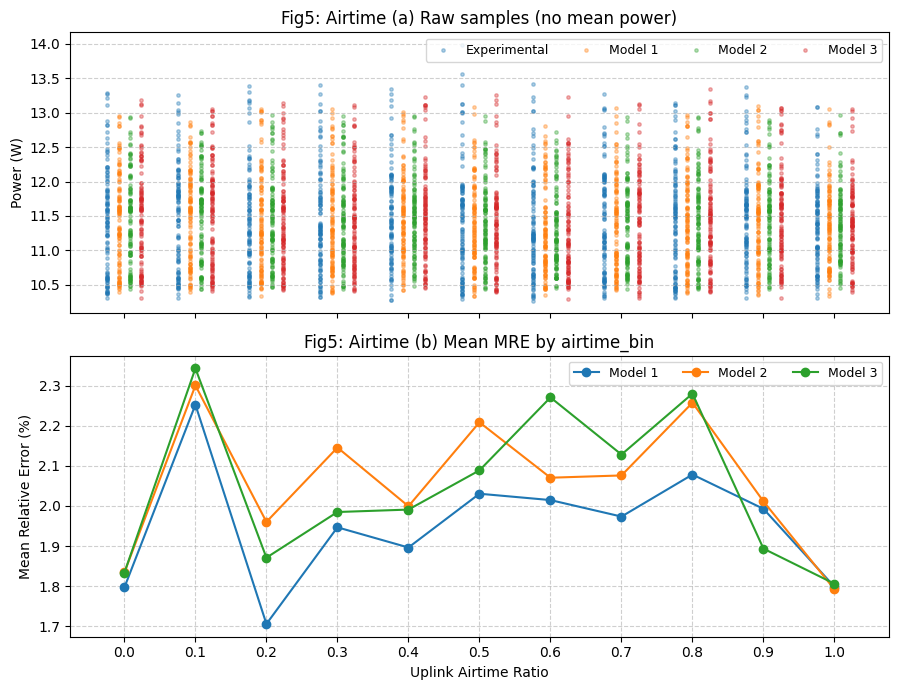

In [50]:
# ============================================================
# Cam-ready style comparison plots for Model1/Model2/Model3
# - Top subplot: raw power samples (no mean power) + predictions
# - Bottom subplot: Mean Relative Error (MRE%) vs x (mean over errors)
# Works for x = txgain / selected_mcs / airtime_bin
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 1) Helper: Mean Relative Error (MRE) in %
# ----------------------------
def mean_relative_error_percent(y_true, y_pred, eps=1e-9):
    """
    Compute mean relative error (percentage).
    MRE% = mean( |y - yhat| / (|y| + eps) ) * 100
    """
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)


# ----------------------------
# 2) Helper: compute mean MRE% per group (group_col)
#    IMPORTANT: we average errors, NOT power
# ----------------------------
def group_mre(df, group_col, true_col="pm_power_true", pred_cols=None, eps=1e-9):
    """
    Return a table: [group_col, pred_m1_mre, pred_m2_mre, pred_m3_mre]
    where each *_mre is mean MRE% within that group.
    """
    if pred_cols is None:
        pred_cols = ["pred_m1", "pred_m2", "pred_m3"]

    out = df[[group_col]].copy()
    y = df[true_col].astype(float).to_numpy()

    for pc in pred_cols:
        yhat = df[pc].astype(float).to_numpy()
        out[f"{pc}_mre"] = np.abs(y - yhat) / (np.abs(y) + eps) * 100

    g = out.groupby(group_col).mean(numeric_only=True).reset_index()
    # Sort groups for a nice left-to-right plot
    g = g.sort_values(group_col).reset_index(drop=True)
    return g


# ----------------------------
# 3) Main plotting function:
#    (a) Raw scatter distributions (no mean power)
#    (b) Mean MRE% curve by x
# ----------------------------
def plot_scatter_and_mre(
    df,
    xcol,
    xlabel,
    title_prefix=None,
    rotate_xticks=0,
    max_points=50000,
    max_xticks=25
):
    """
    df must contain columns:
      - xcol
      - pm_power_true
      - pred_m1, pred_m2, pred_m3

    max_points: optionally downsample for faster plotting (visualization only)
    max_xticks: show at most ~max_xticks x-tick labels (avoid clutter)
    """
    # Keep only needed columns and drop missing values
    d = df[[xcol, "pm_power_true", "pred_m1", "pred_m2", "pred_m3"]].dropna().copy()

    # Optional downsampling (does NOT affect evaluation)
    if (max_points is not None) and (len(d) > max_points):
        d = d.sample(max_points, random_state=0)

    # Try to treat x as numeric (best for sorting)
    x_numeric = pd.to_numeric(d[xcol], errors="coerce")
    if x_numeric.notna().all():
        # All values numeric
        d["_xnum"] = x_numeric
        x_unique = np.sort(d["_xnum"].unique())
    else:
        # Treat as categorical strings
        d["_xnum"] = d[xcol].astype(str)
        x_unique = sorted(d["_xnum"].unique().tolist())

    # Map each unique x to an integer position 0..K-1
    x_map = {v: i for i, v in enumerate(x_unique)}
    d["_xpos"] = d["_xnum"].map(x_map)

    # Small offsets to avoid complete overlap of the 4 scatters
    offsets = {
        "pm_power_true": -0.24,
        "pred_m1":       -0.08,
        "pred_m2":       +0.08,
        "pred_m3":       +0.24
    }

    # Create figure with 2 rows (top scatter, bottom MRE curve)
    fig, axes = plt.subplots(2, 1, figsize=(9, 7), sharex=True)

    # -------- (a) Raw samples + predictions (no averaging power) --------
    ax = axes[0]
    ax.scatter(d["_xpos"] + offsets["pm_power_true"], d["pm_power_true"],
               s=6, alpha=0.35, label="Experimental")
    ax.scatter(d["_xpos"] + offsets["pred_m1"], d["pred_m1"],
               s=6, alpha=0.35, label="Model 1")
    ax.scatter(d["_xpos"] + offsets["pred_m2"], d["pred_m2"],
               s=6, alpha=0.35, label="Model 2")
    ax.scatter(d["_xpos"] + offsets["pred_m3"], d["pred_m3"],
               s=6, alpha=0.35, label="Model 3")

    ax.set_ylabel("Power (W)")
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.legend(ncol=4, fontsize=9)

    if title_prefix:
        ax.set_title(f"{title_prefix} (a) Raw samples (no mean power)")

    # -------- (b) Mean MRE% by x (average errors, not power) --------
    g = group_mre(d, group_col="_xnum")
    g["_xpos"] = g["_xnum"].map(x_map)

    ax2 = axes[1]
    ax2.plot(g["_xpos"], g["pred_m1_mre"], marker="o", label="Model 1")
    ax2.plot(g["_xpos"], g["pred_m2_mre"], marker="o", label="Model 2")
    ax2.plot(g["_xpos"], g["pred_m3_mre"], marker="o", label="Model 3")

    ax2.set_ylabel("Mean Relative Error (%)")
    ax2.set_xlabel(xlabel)
    ax2.grid(True, linestyle="--", alpha=0.6)
    ax2.legend(ncol=3, fontsize=9)

    if title_prefix:
        ax2.set_title(f"{title_prefix} (b) Mean MRE by {xcol}")

    # -------- x-axis ticks (make sparse if too many) --------
    K = len(x_unique)
    step = 1 if K <= max_xticks else int(np.ceil(K / max_xticks))
    tick_pos = np.arange(0, K, step)

    axes[1].set_xticks(tick_pos)
    axes[1].set_xticklabels([x_unique[i] for i in tick_pos], rotation=rotate_xticks)

    plt.tight_layout()
    plt.show()


# ----------------------------
# 4) Build df_test
#    IMPORTANT: Make sure these arrays are from the SAME test split
# ----------------------------
# X_test: test features (numpy array)
# feature_cols: list of feature names in X_test (e.g., ["airtime","selected_mcs","txgain"] or single feature)
# y_true_ul: ground-truth power for test set
# m1_pred_ul/m2_pred_ul/m3_pred_ul: model predictions on test set
# ----------------------------
# Build df_test safely (force same length)
# ----------------------------
X_test_np = np.asarray(X_test)
y_true_np = np.asarray(y_true_ul).reshape(-1)
m1_np = np.asarray(m1_pred_ul).reshape(-1)
m2_np = np.asarray(m2_pred_ul).reshape(-1)
m3_np = np.asarray(m3_pred_ul).reshape(-1)

print("Lengths:")
print("X_test rows:", X_test_np.shape[0])
print("y_true:", len(y_true_np))
print("m1_pred:", len(m1_np))
print("m2_pred:", len(m2_np))
print("m3_pred:", len(m3_np))

# force align by trimming to the minimum length
n = min(X_test_np.shape[0], len(y_true_np), len(m1_np), len(m2_np), len(m3_np))
print("Using n =", n)

X_test_np = X_test_np[:n]
y_true_np = y_true_np[:n]
m1_np = m1_np[:n]
m2_np = m2_np[:n]
m3_np = m3_np[:n]

df_test = pd.DataFrame(X_test_np, columns=feature_cols)
df_test["pm_power_true"] = y_true_np
df_test["pred_m1"] = m1_np
df_test["pred_m2"] = m2_np
df_test["pred_m3"] = m3_np

# airtime bin (if exists)
if "airtime" in df_test.columns:
    df_test["airtime_bin"] = pd.to_numeric(df_test["airtime"], errors="coerce").round(1)

# If airtime exists, create a binned version for a cleaner x-axis
if "airtime" in df_test.columns:
    df_test["airtime_bin"] = pd.to_numeric(df_test["airtime"], errors="coerce").round(1)


# ----------------------------
# 5) Plot Fig2/Fig3/Fig5 (only if the x column exists in df_test)
# ----------------------------

# Fig2: Gain
if "txgain" in df_test.columns:
    plot_scatter_and_mre(
        df_test,
        xcol="txgain",
        xlabel="Uplink Transmission Gain (dB)",
        title_prefix="Fig2: Gain",
        rotate_xticks=0,
        max_points=50000
    )
else:
    print("Skip Fig2 (txgain not found in df_test).")

# Fig3: MCS
if "selected_mcs" in df_test.columns:
    plot_scatter_and_mre(
        df_test,
        xcol="selected_mcs",
        xlabel="Uplink MCS Index",
        title_prefix="Fig3: MCS",
        rotate_xticks=0,
        max_points=50000
    )
else:
    print("Skip Fig3 (selected_mcs not found in df_test).")

# Fig5: Airtime (use airtime_bin for nicer grouping)
if "airtime_bin" in df_test.columns:
    plot_scatter_and_mre(
        df_test.dropna(subset=["airtime_bin"]),
        xcol="airtime_bin",
        xlabel="Uplink Airtime Ratio",
        title_prefix="Fig5: Airtime",
        rotate_xticks=0,
        max_points=50000
    )
else:
    print("Skip Fig5 (airtime/airtime_bin not found in df_test).")



